In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import time
import sys
import gc
import pickle
from itertools import product

from xgboost import XGBRegressor
from xgboost import plot_importance

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/test.csv
/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kaggle/input/competitive-data-science-predict-future-sales/shops.csv


In [2]:
train_data = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv")
test_data = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/test.csv")
items_data = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/items.csv")
shops_data = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/shops.csv")
cate_data = pd.read_csv("/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv")

# EDA

In [3]:
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [4]:
train_data.shape

(2935849, 6)

In [5]:
train_data.isnull().sum()

date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64

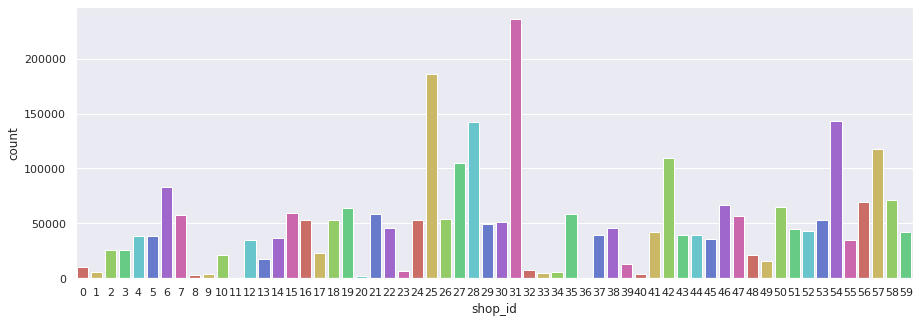

In [6]:
color = sns.color_palette("hls", 8)
sns.set(style="darkgrid")
plt.figure(figsize=(15, 5))
sns.countplot(x=train_data['shop_id'], data=train_data, palette=color)

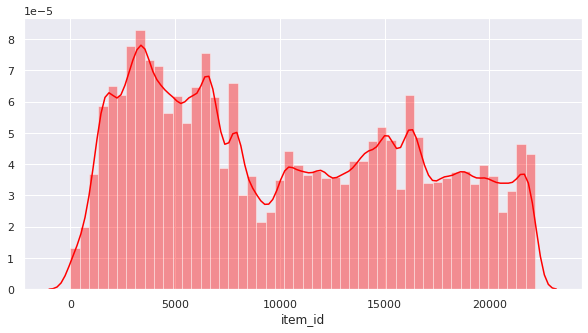

In [7]:
plt.figure(figsize=(10, 5))
sns.distplot(train_data['item_id'], color="red");

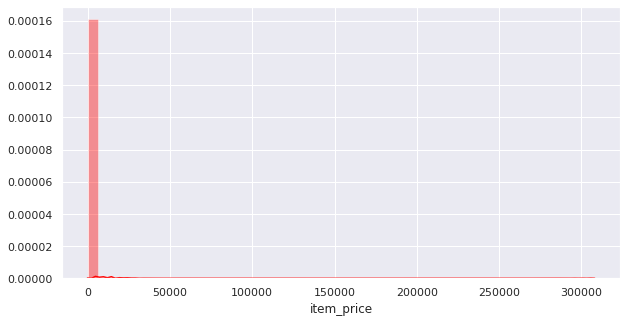

In [8]:
plt.figure(figsize=(10, 5))
sns.distplot(train_data['item_price'], color="red");

/opt/conda/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


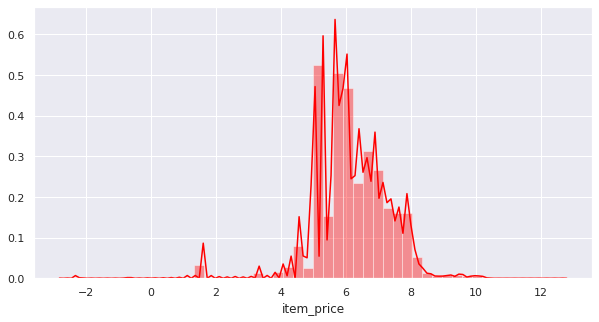

In [9]:
plt.figure(figsize=(10, 5))
sns.distplot(np.log(train_data['item_price']), color="red");

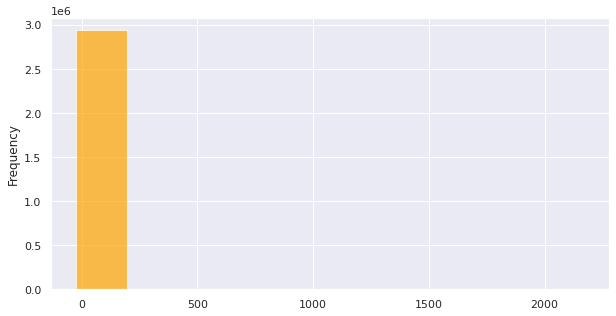

In [10]:
plt.figure(figsize=(10, 5))
train_data['item_cnt_day'].plot(kind='hist', alpha=0.7, color='orange')

In [11]:
test_data.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [12]:
test_data.shape

(214200, 3)

In [13]:
len(test_data['shop_id'].unique())

42

In [14]:
len(test_data['item_id'].unique())

5100

In [15]:
# test_data.groupby(by='shop_id')['item_id'].count()

In [16]:
5100 * 42

214200

thar means every shop has every item

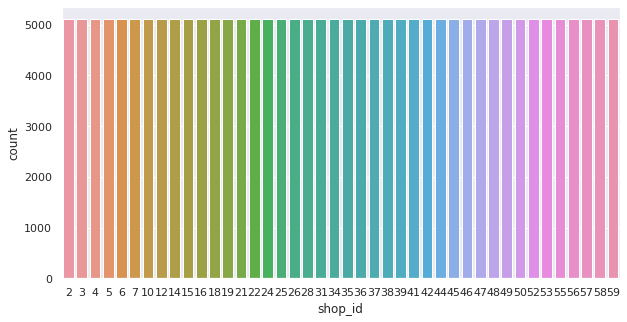

In [17]:
plt.figure(figsize=(10, 5))
sns.countplot(x=test_data['shop_id'], data=test_data)

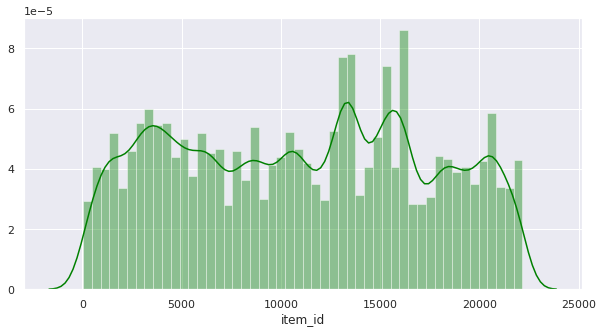

In [18]:
plt.figure(figsize=(10, 5))
sns.distplot(test_data['item_id'], color="green");

# Feature Engineering

## outliers

### handle item_cnt_day outliers

In [19]:
train_data['item_cnt_day'].sort_values(ascending=False).head(5)

2909818    2169.0
2326930    1000.0
2864235     669.0
2851091     637.0
2608040     624.0
Name: item_cnt_day, dtype: float64

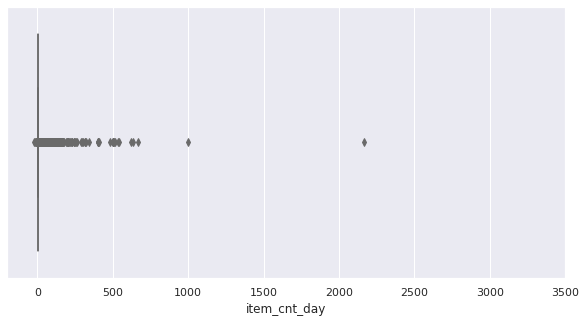

In [20]:
plt.figure(figsize=(10, 5))
color = sns.color_palette("hls", 8)
plt.xlim(-200, 3500)
sns.boxplot(x=train_data.item_cnt_day, color="red", palette="Set3")

In [21]:
train_data = train_data[train_data.item_cnt_day<=1000]

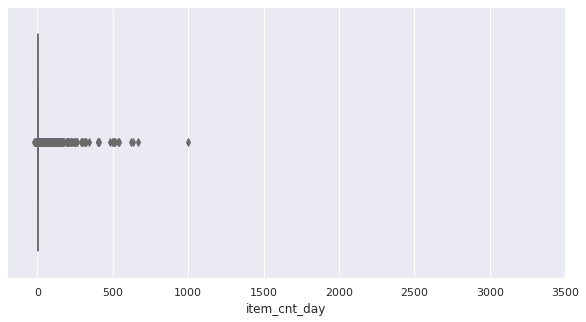

In [22]:
plt.figure(figsize=(10, 5))
color = sns.color_palette("hls", 8)
plt.xlim(-200, 3500)
sns.boxplot(x=train_data.item_cnt_day, color="red", palette="Set3")

### handle item price outliers

In [23]:
train_data['item_price'].sort_values(ascending=False).head()

1163158    307980.0
885138      59200.0
1488135     50999.0
2327159     49782.0
2917760     42990.0
Name: item_price, dtype: float64

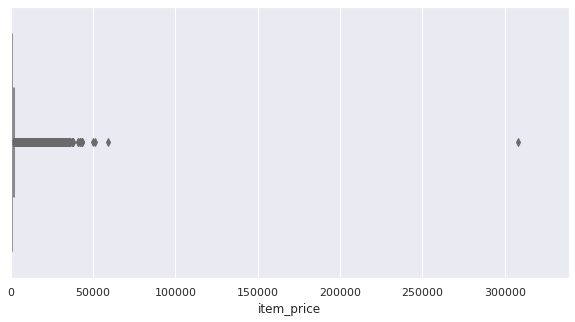

In [24]:
plt.figure(figsize=(10, 5))
color = sns.color_palette("hls", 8)
plt.xlim(train_data.item_price.min(), train_data.item_price.max()*1.1)
sns.boxplot(x=train_data.item_price, color="red", palette="Set3")

In [25]:
train_data = train_data[train_data['item_price'] < 100000]

In [26]:
train_data[train_data['item_price'] < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [27]:
predict_mean_price = train_data[(train_data['date_block_num'] == 4) & (train_data['shop_id'] == 32) & (train_data['item_id'] == 2973) & (train_data['item_price'] > 0)]['item_price'].mean()
predict_mean_price

1874.0

In [28]:
train_data.loc[train_data['item_price'] < 0, 'item_price'] = predict_mean_price

In [29]:
train_data[(train_data['date_block_num'] == 4) & (train_data['shop_id'] == 32) & (train_data['item_id'] == 2973) & (train_data['item_price'] > 0)]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484682,23.05.2013,4,32,2973,1249.0,1.0
484683,15.05.2013,4,32,2973,1874.0,1.0
484684,06.05.2013,4,32,2973,2499.0,1.0


# features analysis

### shops analysis

In [30]:
unq_train_shops = train_data['shop_id'].unique()
unq_test_shops = test_data['shop_id'].unique()
print(len(unq_train_shops))
print(len(unq_test_shops))

60
42


In [31]:
set(unq_test_shops).issubset(set(unq_train_shops))

True

### Handle Duplicate Shops

In [32]:
shops_data.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [33]:
def listToString(s):  
    
    # initialize an empty string 
    str1 = " " 
    
    # return string
    return (str1.join(s))

In [34]:
import re
for i, shop in enumerate(shops_data['shop_name']):
    if i == 6:
        pass
    else:
        string = shop
        cleanString = re.sub(r'[?|$|.|!]',r'',string)
        splitStr = cleanString.split()[:-1]
        finalStr = listToString(splitStr)
        result = shops_data[shops_data['shop_name'].str.contains(finalStr)]
        if result.shape == (2, 2) or result.shape == (0, 2):
            print(result)
            print('-'*50)

                        shop_name  shop_id
0   !Якутск Орджоникидзе, 56 фран        0
57        Якутск Орджоникидзе, 56       57
--------------------------------------------------
                        shop_name  shop_id
1   !Якутск ТЦ "Центральный" фран        1
58        Якутск ТЦ "Центральный"       58
--------------------------------------------------
                      shop_name  shop_id
7        Воронеж ТРЦ "Максимир"        7
8  Воронеж ТРЦ Сити-Парк "Град"        8
--------------------------------------------------
Empty DataFrame
Columns: [shop_name, shop_id]
Index: []
--------------------------------------------------
Empty DataFrame
Columns: [shop_name, shop_id]
Index: []
--------------------------------------------------
                  shop_name  shop_id
13      Казань ТЦ "Бехетле"       13
14  Казань ТЦ "ПаркХаус" II       14
--------------------------------------------------
                        shop_name  shop_id
17  Красноярск ТЦ "Взлетка Плаза"       17
18  

In [35]:
shops_data[shops_data['shop_name'].str.contains('Якутск ТЦ')]

,shop_name,shop_id
1,"!Якутск ТЦ ""Центральный"" фран",1
58,"Якутск ТЦ ""Центральный""",58


In [36]:
train_data.loc[train_data.shop_id == 0, 'shop_id'] = 57
test_data.loc[test_data.shop_id == 0, 'shop_id'] = 57

train_data.loc[train_data.shop_id == 1, 'shop_id'] = 58
test_data.loc[test_data.shop_id == 1, 'shop_id'] = 58

train_data.loc[train_data.shop_id == 10, 'shop_id'] = 11
test_data.loc[test_data.shop_id == 10, 'shop_id'] = 11

### extract city form shops

In [37]:
shops_data.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [38]:
shops_data.loc[shops_data['shop_name'] == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'

In [39]:
shops_data['city'] = shops_data['shop_name'].str.split(' ').map(lambda x:x[0])
shops_data.loc[shops_data['city'] == '!Якутск', 'city'] = 'Якутск'
shops_data.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [40]:
city_label_encoder = preprocessing.LabelEncoder()
shops_data['city_code'] = city_label_encoder.fit_transform(shops_data['city'])

In [41]:
shops_data = shops_data[['shop_id','city_code']]
shops_data.head()

,shop_id,city_code
0,0,29
1,1,29
2,2,0
3,3,1
4,4,2


### Items Analysis

In [42]:
items_data.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [43]:
unq_train_item =  train_data['item_id'].unique()
unq_test_item =  test_data['item_id'].unique()
print(len(unq_train_item))
print(len(unq_test_item))

21806
5100


In [44]:
set(unq_test_item).issubset(set(unq_train_item))

False

In [45]:
len(set(unq_test_item).difference(set(unq_train_item)))

363

In [46]:
cat_in_test_data = items_data.loc[items_data['item_id'].isin(sorted(test_data['item_id'].unique()))].item_category_id.unique()
cat_in_test_data

array([40, 37, 41, 57, 54, 49, 43, 45, 44, 73, 76, 31, 78, 77, 55, 67, 75,
       58, 60, 56, 19, 30, 23, 20, 28, 24, 21, 29, 25, 72, 22, 26, 62, 74,
        0,  2,  5,  3, 35, 65, 27, 12, 64,  7,  6, 15, 34, 33, 16, 38, 42,
       61, 69, 70,  9, 36, 47, 11, 63, 79, 71, 83])

In [47]:
cat_not_in_test = cate_data[~cate_data['item_category_id'].isin(cat_in_test_data)].item_category_id.unique()
cat_not_in_test

array([ 1,  4,  8, 10, 13, 14, 17, 18, 32, 39, 46, 48, 50, 51, 52, 53, 59,
       66, 68, 80, 81, 82])

### Categories Analysis

In [48]:
cate_data.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


In [49]:
splt_cate = cate_data['item_category_name'].str.split('-')
cate_data['main_cate'] = splt_cate.map(lambda x: x[0].strip())
cate_data['main_cate_id'] = preprocessing.LabelEncoder().fit_transform(cate_data['main_cate'])

cate_data['sub_cate'] = splt_cate.map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
cate_data['sub_cate_id'] = preprocessing.LabelEncoder().fit_transform(cate_data['sub_cate'])

cate_data = cate_data[['item_category_id', 'main_cate_id', 'sub_cate_id']]

In [50]:
cate_data.head()

,item_category_id,main_cate_id,sub_cate_id
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


## Matrix shop-item

In [51]:
print('Item not in train:', len(set(unq_test_item).difference(set(unq_train_item))))
print('Total item in test:', len(test_data['item_id'].unique()))
print('Total shop in test:', len(test_data['shop_id'].unique()))

Item not in train: 363
Total item in test: 5100
Total shop in test: 42


In [52]:
ts = time.time()
matrix = []

months = train_data.date_block_num.unique()
for month in months:
    sales = train_data[train_data.date_block_num == month]
    unq_shop = sales['shop_id'].unique()
    unq_item = sales['item_id'].unique()
    append_arr = np.array(list(product(unq_shop, unq_item, [month])), dtype='int16')
    matrix.append(append_arr)

In [53]:
cols = ['shop_id','item_id', 'date_block_num']
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
matrix.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [54]:
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix.sort_values(['date_block_num','shop_id','item_id'],inplace=True)
matrix.head()

,shop_id,item_id,date_block_num
114910,2,19,0
117150,2,27,0
120623,2,28,0
118316,2,29,0
114602,2,32,0


In [55]:
matrix.shape

(10913804, 3)

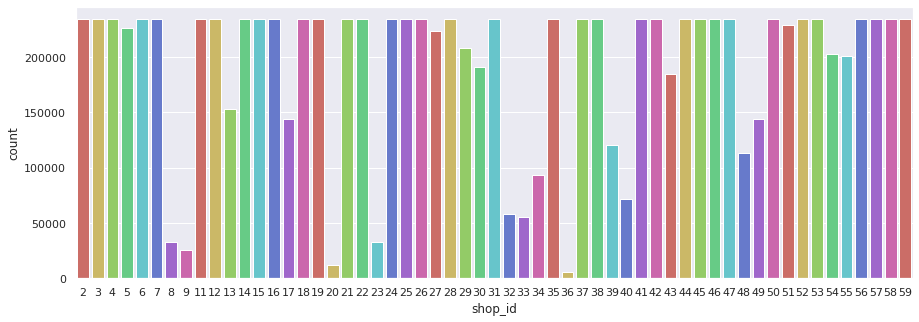

In [56]:
color = sns.color_palette("hls", 8)
sns.set(style="darkgrid")
plt.figure(figsize=(15, 5))
sns.countplot(x=matrix['shop_id'], data=matrix, palette=color)

### Aggregate Sale

In [57]:
train_data['revenue'] = train_data['item_price'] * train_data['item_cnt_day']
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00


In [58]:
group_data = train_data.groupby(by=['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': 'sum'})
group_data.columns = ['item_cnt_month']
group_data.reset_index(inplace = True)
group_data.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,2,27,1.0
1,0,2,33,1.0
2,0,2,317,1.0
3,0,2,438,1.0
4,0,2,471,2.0


In [59]:
matrix = pd.merge(matrix, group_data, on=cols, how='left')
matrix.head()

,shop_id,item_id,date_block_num,item_cnt_month
0,2,19,0,NaN
1,2,27,0,1.0
2,2,28,0,NaN
3,2,29,0,NaN
4,2,32,0,NaN


In [60]:
matrix['item_cnt_month'] = (matrix['item_cnt_month'].fillna(0).clip(0, 20).astype(np.float16))
matrix.head()

,shop_id,item_id,date_block_num,item_cnt_month
0,2,19,0,0.0
1,2,27,0,1.0
2,2,28,0,0.0
3,2,29,0,0.0
4,2,32,0,0.0


In [61]:
matrix.shape

(10913804, 4)

### Concat test into train

In [62]:
test_data.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [63]:
test_data['date_block_num'] = 34
test_data['date_block_num'] = test_data['date_block_num'].astype(np.int8)
test_data['shop_id'] = test_data['shop_id'].astype(np.int8)
test_data['item_id'] = test_data['item_id'].astype(np.int16)

In [64]:
matrix = pd.concat([matrix, test_data], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True)
matrix = matrix.drop('ID', axis=1)
matrix.head()

,shop_id,item_id,date_block_num,item_cnt_month
0,2,19,0,0.0
1,2,27,0,1.0
2,2,28,0,0.0
3,2,29,0,0.0
4,2,32,0,0.0


### Merge (Shops,Items,Cats) features

In [65]:
items_data.drop(['item_name'], axis=1, inplace=True)
items_data.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


In [66]:
cate_data.head()

,item_category_id,main_cate_id,sub_cate_id
0,0,0,29
1,1,1,9
2,2,1,10
3,3,1,11
4,4,1,13


In [67]:
matrix = pd.merge(matrix, shops_data, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items_data, on=['item_id'], how='left')
matrix = pd.merge(matrix, cate_data, on=['item_category_id'], how='left')

In [68]:
matrix.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_code,item_category_id,main_cate_id,sub_cate_id
0,2,19,0,0.0,0,40,11,4
1,2,27,0,1.0,0,19,5,10
2,2,28,0,0.0,0,30,8,55
3,2,29,0,0.0,0,23,5,16
4,2,32,0,0.0,0,40,11,4


In [69]:
matrix['city_code'] = matrix['city_code'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['main_cate_id'] = matrix['main_cate_id'].astype(np.int8)
matrix['sub_cate_id'] = matrix['sub_cate_id'].astype(np.int8)

# Implement Lags

In [70]:
# train_data['date_block_num'] += 9
# train_data.head()
matrix.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_code,item_category_id,main_cate_id,sub_cate_id
0,2,19,0,0.0,0,40,11,4
1,2,27,0,1.0,0,19,5,10
2,2,28,0,0.0,0,30,8,55
3,2,29,0,0.0,0,23,5,16
4,2,32,0,0.0,0,40,11,4


In [71]:
def generate_lag(df, months, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
#     print(tmp)
    for month in months:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id',col+'_lag_'+str(month)]
        shifted['date_block_num'] += month
#         print(month)
#         print(shifted)
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
                      
    return df

In [72]:
matrix = generate_lag(matrix, [1, 2, 3, 6, 12], 'item_cnt_month')
matrix.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_code,item_category_id,main_cate_id,sub_cate_id,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,item_cnt_month_lag_6,item_cnt_month_lag_12
0,2,19,0,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN
1,2,27,0,1.0,0,19,5,10,NaN,NaN,NaN,NaN,NaN
2,2,28,0,0.0,0,30,8,55,NaN,NaN,NaN,NaN,NaN
3,2,29,0,0.0,0,23,5,16,NaN,NaN,NaN,NaN,NaN
4,2,32,0,0.0,0,40,11,4,NaN,NaN,NaN,NaN,NaN


## Features Mean encoding

### date_block_num

In [73]:
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month' : ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left')
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16)
matrix = generate_lag(matrix, [1], 'date_avg_item_cnt')
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True)

### item

In [74]:
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = generate_lag(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)

### shop

In [75]:
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = generate_lag(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)

### item_category_id

In [76]:
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left')
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = generate_lag(matrix, [1], 'date_cat_avg_item_cnt')
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)

### shop and item_category_id

In [77]:
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = generate_lag(matrix, [1], 'date_shop_cat_avg_item_cnt')
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)

### shop and main_cate_id

In [78]:
group = matrix.groupby(['date_block_num', 'shop_id', 'main_cate_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'main_cate_id'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = generate_lag(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)

### shop and sub_cate_id

In [79]:
group = matrix.groupby(['date_block_num', 'shop_id', 'sub_cate_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'sub_cate_id'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = generate_lag(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)

### city_code

In [80]:
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = generate_lag(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)

### item and city_code

In [81]:
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = generate_lag(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)

### main_cate_id

In [82]:
group = matrix.groupby(['date_block_num', 'main_cate_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'main_cate_id'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = generate_lag(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)

### sub_cate_id

In [83]:
group = matrix.groupby(['date_block_num', 'sub_cate_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'sub_cate_id'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = generate_lag(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)

In [84]:
matrix.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_code,item_category_id,main_cate_id,sub_cate_id,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_shop_avg_item_cnt_lag_6,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1
0,2,19,0,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,27,0,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,28,0,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2,29,0,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,32,0,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Trend Analysis

In [85]:
train_data.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
0,02.01.2013,0,59,22154,999.00,1.0,999.00
1,03.01.2013,0,25,2552,899.00,1.0,899.00
2,05.01.2013,0,25,2552,899.00,-1.0,-899.00
3,06.01.2013,0,25,2554,1709.05,1.0,1709.05
4,15.01.2013,0,25,2555,1099.00,1.0,1099.00


In [86]:
group = train_data.groupby(['item_id']).agg({'item_price': ['mean']})
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['item_id'], how='left')
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)
matrix.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_code,item_category_id,main_cate_id,sub_cate_id,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_shop_avg_item_cnt_lag_12,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,item_avg_item_price
0,2,19,0,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.000
1,2,27,0,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1461.000
2,2,28,0,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,310.000
3,2,29,0,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1759.000
4,2,32,0,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,249.625


In [87]:
group = train_data.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']})
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)
matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left')
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)
matrix.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_code,item_category_id,main_cate_id,sub_cate_id,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_cat_avg_item_cnt_lag_1,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,item_avg_item_price,date_item_avg_item_price
0,2,19,0,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28.000,28.0
1,2,27,0,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1461.000,2324.0
2,2,28,0,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,310.000,549.0
3,2,29,0,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1759.000,2398.0
4,2,32,0,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,249.625,338.0


In [88]:
lags = [1,2,3,4,5,6]
matrix = generate_lag(matrix, lags, 'date_item_avg_item_price')
matrix.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_code,item_category_id,main_cate_id,sub_cate_id,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,item_avg_item_price,date_item_avg_item_price,date_item_avg_item_price_lag_1,date_item_avg_item_price_lag_2,date_item_avg_item_price_lag_3,date_item_avg_item_price_lag_4,date_item_avg_item_price_lag_5,date_item_avg_item_price_lag_6
0,2,19,0,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,28.000,28.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2,27,0,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,1461.000,2324.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2,28,0,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,310.000,549.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2,29,0,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,1759.000,2398.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2,32,0,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,249.625,338.0,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
for i in lags:
    matrix['delta_price_lag_'+str(i)] = (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

In [90]:
def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

In [91]:
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price']
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]

matrix.drop(fetures_to_drop, axis=1, inplace=True)

### shop revenue trend

In [92]:
group = train_data.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']})
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']})
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = generate_lag(matrix, [1], 'delta_revenue')

matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)

## Add more features

In [93]:
matrix['month'] = matrix['date_block_num'] % 12
matrix.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_code,item_category_id,main_cate_id,sub_cate_id,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_shop_cat_avg_item_cnt_lag_1,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month
0,2,19,0,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0
1,2,27,0,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0
2,2,28,0,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0
3,2,29,0,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0
4,2,32,0,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0


Number of days in a month. There are no leap years

In [94]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
matrix['days'] = matrix['month'].map(days).astype(np.int8)
matrix.head()

,shop_id,item_id,date_block_num,item_cnt_month,city_code,item_category_id,main_cate_id,sub_cate_id,item_cnt_month_lag_1,item_cnt_month_lag_2,...,date_shop_type_avg_item_cnt_lag_1,date_shop_subtype_avg_item_cnt_lag_1,date_city_avg_item_cnt_lag_1,date_item_city_avg_item_cnt_lag_1,date_type_avg_item_cnt_lag_1,date_subtype_avg_item_cnt_lag_1,delta_price_lag,delta_revenue_lag_1,month,days
0,2,19,0,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31
1,2,27,0,1.0,0,19,5,10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31
2,2,28,0,0.0,0,30,8,55,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31
3,2,29,0,0.0,0,23,5,16,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31
4,2,32,0,0.0,0,40,11,4,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,31


In [95]:
cache = {}
matrix['item_shop_last_sale'] = -1
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)

for idx, row in matrix.iterrows():    
    key = str(row.item_id)+' '+str(row.shop_id)
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        cache[key] = row.date_block_num 

In [96]:
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id
    if key not in cache:
        if row.item_cnt_month!=0:
            cache[key] = row.date_block_num
    else:
        last_date_block_num = cache[key]
        if row.date_block_num>last_date_block_num:
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num
            cache[key] = row.date_block_num         

In [97]:
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')

## Last Preparation

In [98]:
matrix = matrix[matrix.date_block_num > 11]

In [99]:
def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            if ('item_cnt' in col):
                df[col].fillna(0, inplace=True)         
    return df

matrix = fill_na(matrix)

In [100]:
matrix.to_pickle('data.pkl')

In [101]:
gc.collect();

# prediction xgboost

In [102]:
data = pd.read_pickle('data.pkl')

In [103]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'main_cate_id',
    'sub_cate_id',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]]

In [104]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [105]:
model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

[16:45:41] WARNING: /workspace/src/gbm/gbtree.cc:139: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.04941	validation_1-rmse:1.03962
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:0.97155	validation_1-rmse:0.98092
[2]	validation_0-rmse:0.91520	validation_1-rmse:0.94645
[3]	validation_0-rmse:0.88231	validation_1-rmse:0.92947
[4]	validation_0-rmse:0.86515	validation_1-rmse:0.92272
[5]	validation_0-rmse:0.85419	validation_1-rmse:0.91867
[6]	validation_0-rmse:0.84709	validation_1-rmse:0.91848
[7]	validation_0-rmse:0.83929	validation_1-rmse:0.91435
[8]	validation_0-rmse:0.83430	validation_1-rmse:0.91429
[9]	validation_0-rmse:0.83039	validation_1-rmse:0.91531
[10]	validation_0-rmse:0.82788	validation_1-rmse:0.91581
[11]	va

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=300, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=0, num_parallel_tree=1, random_state=42,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42,
             subsample=0.8, tree_method='approx', validate_parameters=1,
             verbosity=None)

In [106]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test_data.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('boost_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

In [107]:
def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

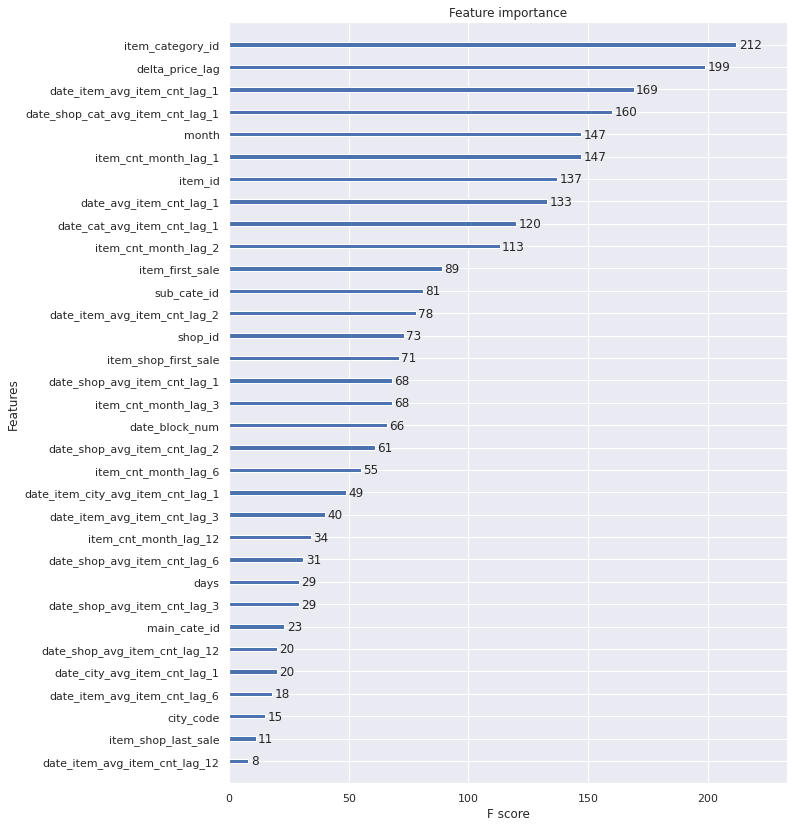

In [108]:
plot_features(model, (10,14))

## Acknowledgement
* https://www.coursera.org/learn/competitive-data-science
* https://www.kaggle.com/plasticgrammer/future-sales-prediction-playground
* https://www.kaggle.com/sarthakbatra/predicting-sales-tutorial
* https://www.kaggle.com/pavansanagapati/feature-engineering-a-comprehensive-tutorial/comments
* https://www.kaggle.com/dlarionov/feature-engineering-xgboost

<h2> Hope It's help you, if yes, Please <i style="color: red;">UPVOTED</i> 👍. Thank you</h2>